<a href="https://colab.research.google.com/github/Parbjot/comp215/blob/main/ProjectComp.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [9]:
import numpy as np
import random
import matplotlib
import matplotlib.pyplot as plt
import re
from matplotlib import animation
import networkx as nx

In [10]:
# Qualitative colour map with value 0 set to white
# tab20_mod = matplotlib.colormaps['tab20']
# tab20_mod.colors = ((1,1,1,1), *tab20_mod.colors[1:])
tab20_mod = plt.cm.get_cmap('tab20', 20)  # Get tab20 colormap with 20 discrete colors
new_colors = np.array(tab20_mod.colors)
new_colors[0] = [1, 1, 1, 1]
tab20_mod = matplotlib.colors.ListedColormap(new_colors)

def plot_2d_array(array, axes=None, title='', cmap=tab20_mod, **options):
    """
    Plot the 2D array as an image on the given axes  1's will be dark blue, 0's will be light blue.

    :param axes: the axes to plot on, or None to use the `plt.gca()` (current axes)
    :param options: keyword arguments passed directly to `plt.imshow()`
           see https://matplotlib.org/stable/api/_as_gen/matplotlib.axes.Axes.imshow.html
    """
    axes = axes or plt.gca()  # If not axes are provided, draw on current axes
    axes.set_title(title)
    # Turn off axes labels and tick marks
    axes.tick_params(axis='both', which='both', bottom=False, top=False, left=False, right=False ,
                     labelbottom=False, labeltop=False, labelleft=False, labelright=False,)
    # Defaults for displaying a "matrix" with hard-pixel boundaries and (0,0) at top-left
    options = {**dict(interpolation='nearest', origin='upper'), **options}
    axes.imshow(array, cmap=cmap, **options)

<ipython-input-10-07d1b7de8b22>:4: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  tab20_mod = plt.cm.get_cmap('tab20', 20)  # Get tab20 colormap with 20 discrete colors


In [11]:
class Animation2D:
    """
      Animates any 2D model with a step() method and a draw() method, using matplotlib
      model.step() should take no parameters - just step the model forward one step.
      model.draw() should take 2 parameters, the matpltolib axes to draw on and an integer step number

      See https://www.allendowney.com/blog/2019/07/25/matplotlib-animation-in-jupyter/
          for a discussion of the pros and cons of various animation techniques in jupyter notebooks
    """

    def __init__(self, model, frames=50, steps_per_frame=1, figsize=(8, 8)):
        """
        :param model: the simulation object to animate, with step() and draw(axes, step) methods
        :param frames: number of animation frames to generate
        """
        self.model = model
        self.frames = frames
        self.steps_per_frame = steps_per_frame
        self.fig, self.ax = plt.subplots(figsize=figsize)

    def animation_step(self, step):
        """ Step the model forward and draw the plot """
        if step > 0:
            for _ in range(self.steps_per_frame):
                self.model.step()
        self.model.draw(self.ax, step=step * self.steps_per_frame)

    def show(self):
        """ return the matplotlib animation object, ready for display """
        anim = animation.FuncAnimation(self.fig, self.animation_step, frames=self.frames)
        plt.close()  # this ensures the last frame is not shown as a separate plot
        return anim

    def animate(self, interval=None):
        """ Animate the model simulation directly in the notebook display block """
        from IPython.display import clear_output
        try:
            for i in range(self.frames):
                clear_output(wait=True)  # clear the IPython display
                self.ax.clear()  # clear old image from the axes (fixes a performance issue)
                plt.figure(self.fig)  # add the figure back to pyplot ** sigh **
                self.animation_step(i)
                plt.show()  # show the current animation frame (pyplot then closes and throws away figure ** sigh **)
                if interval:
                    time.sleep(interval)
        except KeyboardInterrupt:
            pass

In [12]:
# class India:


#    # Rich people alive in the majority (urban areas)
#     Rich_alive_majority = 0

#     # Rich people alive in the minority (rural areas)
#     Rich_alive_minority = 4

#     # Rich people dead in the majority (urban areas)
#     Rich_dead_majority = 1

#     # Rich people dead in the minority (rural areas)
#     Rich_dead_minority = 5

#     # Poor people alive in either majority or minority
#     Poor_alive = 2

#     # Poor people dead in either majority or minority
#     Poor_dead = 3

#     def __init__(self, grid_size):
#               """Initialize the population grid."""
#               self.grid_size = grid_size
#               self.population_grid = np.zeros((grid_size, grid_size), dtype=int)
#               self.setup_initial_population()


#     def setup_initial_population(self):
#         """Randomly initialize the population grid with rich and poor people."""
#         # Top half of the grid is urban (majority), bottom half is rural (minority)
#         urban_grid_size = int(self.grid_size * 0.5)

#         # Populate urban areas with more rich people (higher wealth)
#         self.population_grid[:urban_grid_size, :] = np.random.choice(
#             [self.Rich_alive_majority, self.Rich_dead_majority, self.Poor_alive, self.Poor_dead],
#             size=(urban_grid_size, self.grid_size),
#             p=[0.1, 0.1, 0.5, 0.3]  # Higher chance of being poor in urban areas
#         )

#         # Populate rural areas with more poor people
#         self.population_grid[urban_grid_size:, :] = np.random.choice(
#             [self.Rich_alive_minority, self.Rich_dead_minority, self.Poor_alive, self.Poor_dead],
#             size=(self.grid_size - urban_grid_size, self.grid_size),
#             p=[0.1, 0.6, 0.4, 0.1]  # Higher chance of being poor in rural areas
#         )

class India:
    # States for different conditions in the population model
    Rich_alive_majority = 0
    Rich_alive_minority = 4
    Rich_dead_majority = 1
    Rich_dead_minority = 5
    Poor_alive = 2
    Poor_Dead = 3

    def __init__(self, grid_size):
        """Initialize the population grid."""
        self.grid_size = grid_size
        self.population_grid = np.zeros((grid_size, grid_size), dtype=int)
        self.setup_initial_population()
        print("Initial Population Grid:")
        print(self.population_grid)


    def setup_initial_population(self):
        shape_param = 2.0  # Shape parameter for Pareto (higher values -> less inequality)
        min_wealth = 10  # Minimum wealth level to prevent extreme poverty

        # Pareto distribution for wealth (rescaled to avoid extreme values)
        self.wealth = (np.random.pareto(shape_param, (self.grid_size, self.grid_size)) + 1) * min_wealth
        self.wealth = np.clip(self.wealth, min_wealth, 5 * min_wealth)

        # Median wealth as threshold
        threshold = np.percentile(self.wealth, 50)

        # ❌ OLD: Only two states (0,1)
        # self.population_grid = np.where(self.wealth > threshold, 1, 0)

        # ✅ NEW: Assign Rich/Poor, Alive/Dead properly
        self.population_grid = np.zeros((self.grid_size, self.grid_size), dtype=int)

        for i in range(self.grid_size):
            for j in range(self.grid_size):
                if self.wealth[i, j] > threshold:  # Rich
                    if random.random() < 0.7:  # 70% chance rich are alive
                        self.population_grid[i, j] = self.Rich_alive_majority if i < self.grid_size // 2 else self.Rich_alive_minority
                    else:
                        self.population_grid[i, j] = self.Rich_dead_majority if i < self.grid_size // 2 else self.Rich_dead_minority
                else:  # Poor
                    if random.random() < 0.7:  # 70% chance poor are alive
                        self.population_grid[i, j] = self.Poor_alive
                    else:
                        self.population_grid[i, j] = self.Poor_Dead

        # ✅ Debugging print
        unique, counts = np.unique(self.population_grid, return_counts=True)
        print("Initial Population Distribution:", dict(zip(unique, counts)))


    # def setup_initial_population(self):
    # def setup_initial_population(self):
    #     shape_param = 2.0  # Shape parameter for Pareto (higher values -> less inequality)
    #     min_wealth = 10  # Minimum wealth level to prevent extreme poverty

    #     # Pareto distribution for wealth (rescaled to avoid extreme values)
    #     self.wealth = (np.random.pareto(shape_param, (self.grid_size, self.grid_size)) + 1) * min_wealth

    #     # Normalize the wealth to maintain a reasonable range
    #     self.wealth = np.clip(self.wealth, min_wealth, 5 * min_wealth)

    #     # Assign poor (0) and rich (1) based on a wealth threshold
    #     threshold = np.percentile(self.wealth, 50)  # Median wealth as the threshold
    #     self.population_grid = np.where(self.wealth > threshold, 1, 0)  # 1 = Rich, 0 = Poor

    #     # """Randomly initialize the population grid with rich and poor people."""
    #     # # Top half of the grid is urban (majority), bottom half is rural (minority)
    #     # urban_grid_size = int(self.grid_size * 0.5)  # Urban areas take up the top 50% of the grid

    #     # # Populate urban areas with more rich people (higher wealth)
    #     # self.population_grid[:urban_grid_size, :] = np.random.choice(
    #     #     [self.Rich_alive_majority, self.Rich_dead_majority, self.Poor_alive, self.Poor_dead],
    #     #     size=(urban_grid_size, self.grid_size),
    #     #     p=[0.3, 0.1, 0.5, 0.1]  # Higher chance of being poor in urban areas
    #     # )

    #     # # Populate rural areas with more poor people (lower wealth)
    #     # self.population_grid[urban_grid_size:, :] = np.random.choice(
    #     #     [self.Rich_alive_minority, self.Rich_dead_minority, self.Poor_alive, self.Poor_dead],
    #     #     size=(self.grid_size - urban_grid_size, self.grid_size),
    #     #     p=[0.1, 0.1, 0.7, 0.1]  # Higher chance of being poor in rural areas
    #     # )

    def survival_probability(self, wealth_status, region_type):
        """Returns a survival probability based on wealth status and region type."""
        if region_type == 'rural':
            if wealth_status == self.Poor_alive:
                return random.random() < 0.75  # Poor have higher survival in rural
            else:
                return random.random() < 0.5  # Rich have lower survival in rural
        else:
            if wealth_status == self.Poor_alive:
                return random.random() < 0.45  # Poor have lower survival in urban
            else:
                return random.random() < 0.65  # Rich have higher survival in urban

    def birth_probability(self, wealth_status, region_type):
        """Returns birth probability based on wealth and region type."""
        if region_type == 'rural':
            if wealth_status == self.Poor_alive:
                return random.random() < 0.03  # Higher birth rate in rural poor
            else:
                return random.random() < 0.01  # Lower birth rate for rich
        else:
            if wealth_status == self.Poor_alive:
                return random.random() < 0.02  # Lower birth rate in urban poor
            else:
                return random.random() < 0.01  # Very low birth rate for rich

    def update_population(self):
        """Update the population grid with survival and birth probabilities."""
        new_grid = self.population_grid.copy()

        for i in range(self.grid_size):
            for j in range(self.grid_size):
                # Determine if the cell is urban or rural based on its row
                region_type = 'urban' if i < self.grid_size // 2 else 'rural'
                wealth_status = self.population_grid[i, j]

                # Check survival
                if wealth_status != self.Poor_dead and wealth_status != self.Rich_dead_majority and wealth_status != self.Rich_dead_minority:
                    survives = self.survival_probability(wealth_status, region_type)
                    if not survives:
                        if wealth_status == self.Rich_alive_majority or wealth_status == self.Rich_alive_minority:
                            new_grid[i, j] = self.Rich_dead_majority if region_type == 'urban' else self.Rich_dead_minority
                        else:
                            new_grid[i, j] = self.Poor_Dead

                # Check for births
                if wealth_status == self.Poor_alive or wealth_status == self.Rich_alive_majority or wealth_status == self.Rich_alive_minority:
                    gives_birth = self.birth_probability(wealth_status, region_type)
                    if gives_birth:
                        if region_type == 'urban':
                            new_grid[i, j] = self.Poor_alive if random.random() < 0.5 else self.Rich_alive_majority
                        else:
                            new_grid[i, j] = self.Poor_alive

        self.population_grid = new_grid

    def plot_population(self):
        """Visualize the population grid using custom colormap."""
        plot_2d_array(self.population_grid, title="Population Grid", cmap=tab20_mod)

    def run_simulation(self, generations=10):
        """Run the simulation for a given number of generations."""
        for generation in range(generations):
            self.update_population()
            self.plot_population()
            print(f"Generation {generation + 1} completed.")
    def Animmate(self):
        Animation2D(self.population_grid)

# class IndiaWealthModel:
#     def __init__(self, grid_size=50, initial_wealth=100, connectivity=3):
#         self.grid_size = grid_size
#         self.population_grid = np.zeros((grid_size, grid_size))
#         self.wealth = np.full((grid_size, grid_size), initial_wealth, dtype=float)
#         self.G = nx.grid_2d_graph(grid_size, grid_size)
#         self.setup_initial_population()
#         self.setup_economic_network(connectivity)

#     def setup_initial_population(self):
#         shape_param = 2.0  # Shape parameter for Pareto (higher values -> less inequality)
#         min_wealth = 10  # Minimum wealth level to prevent extreme poverty

#         # Pareto distribution for wealth (rescaled to avoid extreme values)
#         self.wealth = (np.random.pareto(shape_param, (self.grid_size, self.grid_size)) + 1) * min_wealth
#         self.wealth = np.clip(self.wealth, min_wealth, 5 * min_wealth)

#         # Median wealth as threshold
#         threshold = np.percentile(self.wealth, 50)

#         # ❌ OLD: Only two states (0,1)
#         # self.population_grid = np.where(self.wealth > threshold, 1, 0)

#         # ✅ NEW: Assign Rich/Poor, Alive/Dead properly
#         self.population_grid = np.zeros((self.grid_size, self.grid_size), dtype=int)

#         for i in range(self.grid_size):
#             for j in range(self.grid_size):
#                 if self.wealth[i, j] > threshold:  # Rich
#                     if random.random() < 0.7:  # 70% chance rich are alive
#                         self.population_grid[i, j] = self.Rich_alive_majority if i < self.grid_size // 2 else self.Rich_alive_minority
#                     else:
#                         self.population_grid[i, j] = self.Rich_dead_majority if i < self.grid_size // 2 else self.Rich_dead_minority
#                 else:  # Poor
#                     if random.random() < 0.7:  # 70% chance poor are alive
#                         self.population_grid[i, j] = self.Poor_alive
#                     else:
#                         self.population_grid[i, j] = self.Poor_dead

#         # ✅ Debugging print
#         unique, counts = np.unique(self.population_grid, return_counts=True)
#         print("Initial Population Distribution:", dict(zip(unique, counts)))



    def setup_economic_network(self, connectivity):
        for node in self.G.nodes():
            x, y = node
            neighbors = [(x + dx, y + dy) for dx, dy in
                         [(-1, 0), (1, 0), (0, -1), (0, 1)]
                         if 0 <= x + dx < self.grid_size and 0 <= y + dy < self.grid_size]
            self.G.add_edges_from([(node, neighbor) for neighbor in neighbors[:connectivity]])

    def economic_exchange(self):
        for node in self.G.nodes():
            x, y = node
            if self.population_grid[x, y] == 1:  # If rich
                neighbors = list(self.G.neighbors(node))
                if neighbors:
                    target = random.choice(neighbors)
                    tx, ty = target
                    self.wealth[x, y] -= 1
                    self.wealth[tx, ty] += 1

    def step(self):
        self.economic_exchange()
        self.population_grid = np.where(self.wealth > 50, 1, 0)  # Wealth threshold for richness

    def draw(self, ax, step):
        ax.clear()
        ax.set_title(f'Step {step}')
        ax.imshow(self.population_grid, cmap='coolwarm')

    def animate(self, frames=50):
      fig, ax = plt.subplots()
      self.anim = animation.FuncAnimation(fig, lambda i: [self.step(), self.draw(ax, i)], frames=frames)
      plt.show()

# Run Model
# model = IndiaWealthModel(grid_size=50)
# model.animate(frames=100)


Initial Population Distribution: {np.int64(0): np.int64(1749), np.int64(1): np.int64(751), np.int64(2): np.int64(3553), np.int64(3): np.int64(1447), np.int64(4): np.int64(1762), np.int64(5): np.int64(738)}
Initial Population Grid:
[[1 3 1 ... 3 1 0]
 [2 2 3 ... 0 0 0]
 [2 3 0 ... 3 1 3]
 ...
 [2 3 4 ... 2 2 4]
 [4 4 5 ... 2 2 4]
 [5 4 4 ... 2 4 4]]
Initial Population Distribution: {np.int64(0): np.int64(465), np.int64(1): np.int64(162), np.int64(2): np.int64(864), np.int64(3): np.int64(386), np.int64(4): np.int64(437), np.int64(5): np.int64(186)}
Initial Population Grid:
[[3 0 2 ... 2 2 1]
 [3 0 2 ... 0 1 2]
 [0 1 1 ... 1 2 0]
 ...
 [4 4 3 ... 3 2 3]
 [2 2 4 ... 4 2 4]
 [5 4 2 ... 4 4 5]]


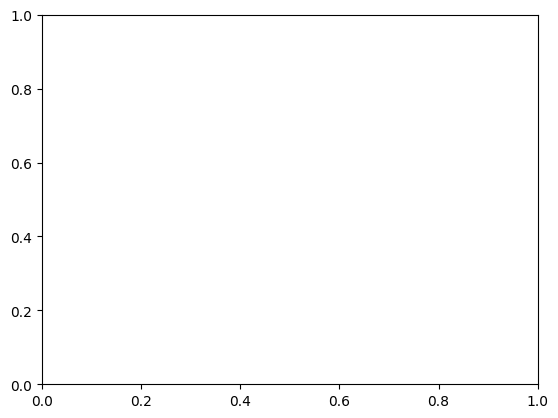

In [13]:
# Initialize India population model with a grid size of 20x20
# india_model = India(grid_size=10)

# Run the simulation for 10 generations
# india_model.run_simulation(generations=1000)
india_sim = India(grid_size=100)
model = India(grid_size=50)
model.animate(frames=100)
 # Animate over 50 frames with a 500ms interval between frames